# NLP EXPERIMENTS AND FIGURES

## DESCRIPTION
The objective of this analysis was to study possible insights about performing n-year cancer survival prediction using unstructured medical text notes. We explore the convenience to use clinical text to show that even applying simple feature transformations to the text like term-frequency inverse document-frequency (TF-IDF), it can be a most accurate way to predict survival than classical stage/grade used in the clinic. It is out of the scope of this study to apply the state of the art for NLP text classification problems. We selected patients with breast, glioma, lung and prostate cancer. Each cancer type was treated as a separate study but followed the same methodology.

## STATEMENT
 This file is part of <https://github.com/medomics>, a package providing 
 research utility tools for developing precision medicine applications.
 
 --> Copyright (C) 2020  MEDomics consortium

     This package is free software: you can redistribute it and/or modify
     it under the terms of the GNU General Public License as published by
     the Free Software Foundation, either version 3 of the License, or
     (at your option) any later version.

     This package is distributed in the hope that it will be useful,
     but WITHOUT ANY WARRANTY; without even the implied warranty of
     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
     GNU General Public License for more details.
 
     You should have received a copy of the GNU General Public License
     along with this package.  If not, see <http://www.gnu.org/licenses/>.

## IMPORTS

In [1]:
import re
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')

## DEFINE PLOTS

In [2]:
def plot_test(results, disease, period_of_analysis_days=None):
    """This funtion plot the experiment results."""
    disease_name = ''
    if disease[0] == 'g':
        disease_name = 'Glioma'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'p':
        disease_name = 'Prostate'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'l':
        disease_name = 'Lung'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'b':
        disease_name = 'Breast'
        label_stage = 'Stage/Grade'

    sns.set(style="darkgrid")
    mean_f1_list = []
    mean_f1_s_list = []

    for result_i in results:
        mean_f1_list.append(list(map(lambda x: x[0], result_i['f1'])))
        mean_f1_s_list.append(list(map(lambda x: x[0], result_i['f1_s'])))

    mean_f1 = np.array(mean_f1_list).mean(axis=0)
    std_f1 = np.array(mean_f1_list).std(axis=0)
    mean_f1_s = np.array(mean_f1_s_list).mean(axis=0)
    std_f1_s = np.array(mean_f1_s_list).std(axis=0)
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10, 5))
    plt.xlim((0, 380))
    plt.ylim((0.5, 0.9))
    plt.xlabel("Days After Diagnosis")
    plt.ylabel("F1 Score")
    plt.title(
        f"{disease_name} start {str(period_of_analysis_days[0])} days, Train Set Size: {results[0]['n'][-1]}, Test Set Size: {results[0]['n_test'][-1]}")

    plt.xticks(np.arange(0, 380, step=60))
    plt.errorbar(period_of_analysis_days, mean_f1, yerr=std_f1, label='NLP')
    plt.errorbar(period_of_analysis_days, mean_f1_s,
                 yerr=std_f1_s, label=label_stage)
    plt.legend(loc='lower right')
    os.makedirs('EPS_experiment', 0o777, True)    
    plt.savefig(
        f'EPS_experiment/{disease}{str(period_of_analysis_days[0])}.eps', format='eps')


In [3]:
def plot_test_age(results, disease, period_of_analysis_days=None, point=-4):
    """This funtion plot the test set age distribution in one point of the
    experiment."""
    
    disease_name = ''
    if disease == 'g':
        disease_name = 'Glioma'
    elif disease == 'p':
        disease_name = 'Prostate'
    elif disease == 'l':
        disease_name = 'Lung'
    elif disease == 'b':
        disease_name = 'Breast'

    sns.set(style="darkgrid")
    mean_tfidf_age_list_0 = []
    mean_tfidf_age_list_1 = []
    mean_label_age_list_0 = []
    mean_label_age_list_1 = []
    for results_i in results:
        tfidf_age_list_0 = []
        tfidf_age_list_1 = []
        label_age_list_0 = []
        label_age_list_1 = []
        for test_i in results_i['test']:
            colum_name = [x for x in test_i.columns.tolist()
                          if re.search('_tf_pred', x)][0]
            tfidf_age_list_0.append(
                test_i[test_i[colum_name] == 0]['ageatdx'].astype('float').mean())
            tfidf_age_list_1.append(
                test_i[test_i[colum_name] == 1]['ageatdx'].astype('float').mean())
            label_age_list_0.append(
                test_i[test_i['label'] == 0]['ageatdx'].astype('float').mean())
            label_age_list_1.append(
                test_i[test_i['label'] == 1]['ageatdx'].astype('float').mean())
        mean_tfidf_age_list_0.append(list(tfidf_age_list_0))
        mean_tfidf_age_list_1.append(list(tfidf_age_list_1))
        mean_label_age_list_0.append(list(label_age_list_0))
        mean_label_age_list_1.append(list(label_age_list_1))

    mean_tfidf_0 = np.array(mean_tfidf_age_list_0).mean(axis=0)
    mean_tfidf_1 = np.array(mean_tfidf_age_list_1).mean(axis=0)
    std_tfidf_0 = np.array(mean_tfidf_age_list_0).std(axis=0)
    std_tfidf_1 = np.array(mean_tfidf_age_list_1).std(axis=0)
    mean_label_0 = np.array(mean_label_age_list_0).mean(axis=0)
    mean_label_1 = np.array(mean_label_age_list_1).mean(axis=0)
    std_label_0 = np.array(mean_label_age_list_0).std(axis=0)
    std_label_1 = np.array(mean_label_age_list_1).std(axis=0)

    labels = ['Non-Survivors', 'Survivors']
    tfidf = [mean_tfidf_0[point], mean_tfidf_1[point]]
    tfidf_std = [std_tfidf_0[point], std_tfidf_1[point]]
    label = [mean_label_0[point], mean_label_1[point]]
    label_std = [std_label_0[point], std_label_1[point]]
    x = np.arange(len(labels))  # the label locations
    width = 0.35                # the width of the bars
    plt.figure(figsize=(5, 5))
    plt.bar(x - width/2, tfidf, width, label='NLP', yerr=tfidf_std)
    plt.bar(x + width/2, label, width, label='G-Truth', yerr=label_std)

    plt.ylabel('age')
    plt.xticks(x, labels)
    plt.legend()
    plt.title(
        f"{disease_name} {period_of_analysis_days[point]} days, Train Set Size: {results[0]['n'][-1]}, Test Set Size: {results[0]['n_test'][-1]}")
    plt.ylim((0, 80))
    os.makedirs('EPS_age', 0o777, True)     
    plt.savefig(f'EPS_age/{disease}{period_of_analysis_days[0]}-point{period_of_analysis_days[point]}-age.eps', format='eps')

In [4]:
def plot_test_stage(results, disease, period_of_analysis_days=None,stage_colname='stage_grade',point = -4):
    """This funtion plot the test set stage/grade distribution in one point of
    the experiment."""

    disease_name = ''
    if disease == 'g':
        disease_name = 'Glioma'
    elif disease == 'p':
        disease_name = 'Prostate'
    elif disease == 'l':
        disease_name = 'Lung'
    elif disease == 'b':
        disease_name = 'Breast'

    sns.set(style="darkgrid")
    mean_tfidf_s_list_0_4 = []
    mean_tfidf_s_list_0_3 = []
    mean_tfidf_s_list_0_2 = []
    mean_tfidf_s_list_0_UNK = []
    mean_tfidf_s_list_1_4 = []
    mean_tfidf_s_list_1_3 = []
    mean_tfidf_s_list_1_2 = []
    mean_tfidf_s_list_1_UNK = []
    mean_label_s_list_0_4 = []
    mean_label_s_list_0_3 = []
    mean_label_s_list_0_2 = []
    mean_label_s_list_0_UNK = []
    mean_label_s_list_1_4 = []
    mean_label_s_list_1_3 = []
    mean_label_s_list_1_2 = []
    mean_label_s_list_1_UNK = []

    for results_i in results:
        tfidf_s_list_0_4 = []
        tfidf_s_list_0_3 = []
        tfidf_s_list_0_2 = []
        tfidf_s_list_0_UNK = []
        tfidf_s_list_1_4 = []
        tfidf_s_list_1_3 = []
        tfidf_s_list_1_2 = []
        tfidf_s_list_1_UNK = []
        label_s_list_0_4 = []
        label_s_list_0_3 = []
        label_s_list_0_2 = []
        label_s_list_0_UNK = []
        label_s_list_1_4 = []
        label_s_list_1_3 = []
        label_s_list_1_2 = []
        label_s_list_1_UNK = []
        for test_i in results_i['test']:
            colum_name = [x for x in test_i.columns.tolist()
                          if re.search('_tf_pred', x)][0]
            if "ctnmstagegroup_3G" in test_i.columns:
                stage_colname = "ctnmstagegroup_3G"
            else:
                stage_colname = stage_colname 
                
            tfidf_s_list_0_4.append(test_i[(test_i[colum_name] == 0) & (
                test_i[stage_colname] == '4')][stage_colname].count())
            tfidf_s_list_0_3.append(test_i[(test_i[colum_name] == 0) & (
                test_i[stage_colname] == '3')][stage_colname].count())
            tfidf_s_list_0_2.append(test_i[(test_i[colum_name] == 0) & (
                (test_i[stage_colname] == '1-2') | (test_i[stage_colname] == '0-2'))][stage_colname].count())
            tfidf_s_list_0_UNK.append(test_i[(test_i[colum_name] == 0) & (
                test_i[stage_colname] == 'UNKNOWN')][stage_colname].count())
            tfidf_s_list_1_4.append(test_i[(test_i[colum_name] == 1) & (
                test_i[stage_colname] == '4')][stage_colname].count())
            tfidf_s_list_1_3.append(test_i[(test_i[colum_name] == 1) & (
                test_i[stage_colname] == '3')][stage_colname].count())
            tfidf_s_list_1_2.append(test_i[(test_i[colum_name] == 1) & (
                (test_i[stage_colname] == '1-2') | (test_i[stage_colname] == '0-2'))][stage_colname].count())
            tfidf_s_list_1_UNK.append(test_i[(test_i[colum_name] == 1) & (
                test_i[stage_colname] == 'UNKNOWN')][stage_colname].count())
            label_s_list_0_4.append(test_i[(test_i['label'] == 0) & (
                test_i[stage_colname] == '4')][stage_colname].count())
            label_s_list_0_3.append(test_i[(test_i['label'] == 0) & (
                test_i[stage_colname] == '3')][stage_colname].count())
            label_s_list_0_2.append(test_i[(test_i['label'] == 0) & (
                (test_i[stage_colname] == '1-2') | (test_i[stage_colname] == '0-2'))][stage_colname].count())
            label_s_list_0_UNK.append(test_i[(test_i['label'] == 0) & (
                test_i[stage_colname] == 'UNKNOWN')][stage_colname].count())
            label_s_list_1_4.append(test_i[(test_i['label'] == 1) & (
                test_i[stage_colname] == '4')][stage_colname].count())
            label_s_list_1_3.append(test_i[(test_i['label'] == 1) & (
                test_i[stage_colname] == '3')][stage_colname].count())
            label_s_list_1_2.append(test_i[(test_i['label'] == 1) & (
                (test_i[stage_colname] == '1-2') | (test_i[stage_colname] == '0-2'))][stage_colname].count())
            label_s_list_1_UNK.append(test_i[(test_i['label'] == 1) & (
                test_i[stage_colname] == 'UNKNOWN')][stage_colname].count())

        mean_tfidf_s_list_0_4.append(list(tfidf_s_list_0_4))
        mean_tfidf_s_list_0_3.append(list(tfidf_s_list_0_3))
        mean_tfidf_s_list_0_2.append(list(tfidf_s_list_0_2))
        mean_tfidf_s_list_0_UNK.append(list(tfidf_s_list_0_UNK))
        mean_tfidf_s_list_1_4.append(list(tfidf_s_list_1_4))
        mean_tfidf_s_list_1_3.append(list(tfidf_s_list_1_3))
        mean_tfidf_s_list_1_2.append(list(tfidf_s_list_1_2))
        mean_tfidf_s_list_1_UNK.append(list(tfidf_s_list_1_UNK))

        mean_label_s_list_0_4.append(list(label_s_list_0_4))
        mean_label_s_list_0_3.append(list(label_s_list_0_3))
        mean_label_s_list_0_2.append(list(label_s_list_0_2))
        mean_label_s_list_0_UNK.append(list(label_s_list_0_UNK))
        mean_label_s_list_1_4.append(list(label_s_list_1_4))
        mean_label_s_list_1_3.append(list(label_s_list_1_3))
        mean_label_s_list_1_2.append(list(label_s_list_1_2))
        mean_label_s_list_1_UNK.append(list(label_s_list_1_UNK))

    mean_tfidf_0_4 = np.array(mean_tfidf_s_list_0_4).mean(axis=0)
    mean_tfidf_0_3 = np.array(mean_tfidf_s_list_0_3).mean(axis=0)
    mean_tfidf_0_2 = np.array(mean_tfidf_s_list_0_2).mean(axis=0)
    mean_tfidf_0_UNK = np.array(mean_tfidf_s_list_0_UNK).mean(axis=0)

    mean_tfidf_1_4 = np.array(mean_tfidf_s_list_1_4).mean(axis=0)
    mean_tfidf_1_3 = np.array(mean_tfidf_s_list_1_3).mean(axis=0)
    mean_tfidf_1_2 = np.array(mean_tfidf_s_list_1_2).mean(axis=0)
    mean_tfidf_1_UNK = np.array(mean_tfidf_s_list_1_UNK).mean(axis=0)

    std_tfidf_0_4 = np.array(mean_tfidf_s_list_0_4).std(axis=0)
    std_tfidf_0_3 = np.array(mean_tfidf_s_list_0_3).std(axis=0)
    std_tfidf_0_2 = np.array(mean_tfidf_s_list_0_2).std(axis=0)
    std_tfidf_0_UNK = np.array(mean_tfidf_s_list_0_UNK).std(axis=0)

    std_tfidf_1_4 = np.array(mean_tfidf_s_list_1_4).std(axis=0)
    std_tfidf_1_3 = np.array(mean_tfidf_s_list_1_3).std(axis=0)
    std_tfidf_1_2 = np.array(mean_tfidf_s_list_1_2).std(axis=0)
    std_tfidf_1_UNK = np.array(mean_tfidf_s_list_1_UNK).std(axis=0)

    mean_label_0_4 = np.array(mean_label_s_list_0_4).mean(axis=0)
    mean_label_0_3 = np.array(mean_label_s_list_0_3).mean(axis=0)
    mean_label_0_2 = np.array(mean_label_s_list_0_2).mean(axis=0)
    mean_label_0_UNK = np.array(mean_label_s_list_0_UNK).mean(axis=0)

    mean_label_1_4 = np.array(mean_label_s_list_1_4).mean(axis=0)
    mean_label_1_3 = np.array(mean_label_s_list_1_3).mean(axis=0)
    mean_label_1_2 = np.array(mean_label_s_list_1_2).mean(axis=0)
    mean_label_1_UNK = np.array(mean_label_s_list_1_UNK).mean(axis=0)

    std_label_0_4 = np.array(mean_label_s_list_0_4).std(axis=0)
    std_label_0_3 = np.array(mean_label_s_list_0_3).std(axis=0)
    std_label_0_2 = np.array(mean_label_s_list_0_2).std(axis=0)
    std_label_0_UNK = np.array(mean_label_s_list_0_UNK).std(axis=0)

    std_label_1_4 = np.array(mean_label_s_list_1_4).std(axis=0)
    std_label_1_3 = np.array(mean_label_s_list_1_3).std(axis=0)
    std_label_1_2 = np.array(mean_label_s_list_1_2).std(axis=0)
    std_label_1_UNK = np.array(mean_label_s_list_1_UNK).std(axis=0)

    labels = ['Non-Survivors', 'Survivors']
    tfidf_4 = np.array([mean_tfidf_0_4[point], mean_tfidf_1_4[point]])
    tfidf_std_4 = np.array([std_tfidf_0_4[point], std_tfidf_1_4[point]])
    tfidf_3 = np.array([mean_tfidf_0_3[point], mean_tfidf_1_3[point]])
    tfidf_std_3 = np.array([std_tfidf_0_3[point], std_tfidf_1_3[point]])
    tfidf_2 = np.array([mean_tfidf_0_2[point], mean_tfidf_1_2[point]])
    tfidf_std_2 = np.array([std_tfidf_0_2[point], std_tfidf_1_2[point]])
    tfidf_UNK = np.array([mean_tfidf_0_UNK[point], mean_tfidf_1_UNK[point]])
    tfidf_std_UNK = np.array([std_tfidf_0_UNK[point], std_tfidf_1_UNK[point]])

    label_4 = np.array([mean_label_0_4[point], mean_label_1_4[point]])
    label_std_4 = np.array([std_label_0_4[point], std_label_1_4[point]])
    label_3 = np.array([mean_label_0_3[point], mean_label_1_3[point]])
    label_std_3 = np.array([std_label_0_3[point], std_label_1_3[point]])
    label_2 = np.array([mean_label_0_2[point], mean_label_1_2[point]])
    label_std_2 = np.array([std_label_0_2[point], std_label_1_2[point]])
    label_UNK = np.array([mean_label_0_UNK[point], mean_label_1_UNK[point]])
    label_std_UNK = np.array([std_label_0_UNK[point], std_label_1_UNK[point]])

    N = 2
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35          # the width of the bars

    plt.figure(figsize=(5, 5))
    p1 = plt.bar(ind - width/2, tfidf_4, width, yerr=tfidf_std_4, color='blue')
    
    p2 = plt.bar(ind - width/2, tfidf_3, width,
                 bottom=tfidf_4, yerr=tfidf_std_3, color='red')
    p3 = plt.bar(ind - width/2, tfidf_2, width, bottom=tfidf_4 +
                 tfidf_3, yerr=tfidf_std_2, color='orange')
    p4 = plt.bar(ind - width/2, tfidf_UNK, width, bottom=tfidf_4 +
                 tfidf_3+tfidf_2, yerr=tfidf_std_UNK, color='green')

    p1 = plt.bar(ind + width/2, label_4, width, yerr=label_std_4, color='blue')
    p2 = plt.bar(ind + width/2, label_3, width,
                 bottom=label_4, yerr=label_std_3, color='red')
    p3 = plt.bar(ind + width/2, label_2, width, bottom=label_4 +
                 label_3, yerr=label_std_2, color='orange')
    p4 = plt.bar(ind + width/2, label_UNK, width, bottom=label_4 +
                 label_3+label_2, yerr=label_std_UNK, color='green')
    
    plt.ylabel('Number of Patients')
    plt.xticks(ind, labels)

    plt.title(
        f"{disease_name} {period_of_analysis_days[point]} days, Train Set Size: {results[0]['n'][-1]}, Test Set Size: {results[0]['n_test'][-1]}")
    
        
    plt.legend((p1[0], p2[0], p3[0], p4[0]), ('4', '3', 'LOW', 'UNK'))
       
    os.makedirs('EPS_stage', 0o777, True)    
    plt.savefig(
        f'EPS_stage/{disease}{period_of_analysis_days[0]}-point{period_of_analysis_days[point]}-stage.eps', format='eps')


## PLOT RESULTS

In [5]:
# List of pickle names for each experiment with the time series used.

list_of_pickle_names = [['glioma20', [20, 60, 120, 180, 240, 300, 365]],
                        ['glioma30', [30, 60, 120, 180, 240, 300, 365]],
                        ['glioma60', [60, 120, 180, 240, 300, 365]],
                        ['prostate20', [20, 60, 120, 180, 240, 300, 365]],
                        ['prostate30', [30, 60, 120, 180, 240, 300, 365]],
                        ['prostate60', [60, 120, 180, 240, 300, 365]],
                        ['breast20', [20, 60, 120, 180, 240, 300, 365]],
                        ['breast30', [30, 60, 120, 180, 240, 300, 365]],
                        ['breast60', [60, 120, 180, 240, 300, 365]],
                        ['lung20', [20, 60, 120, 180, 240, 300, 365]],
                        ['lung30', [30, 60, 120, 180, 240, 300, 365]],
                        ['lung60', [60, 120, 180, 240, 300, 365]]]



In [6]:
# De-identified pickle files PATH and SUFFIX
PATH = './DEID_EXP_FILES/'
SUFFIX = '_deid'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

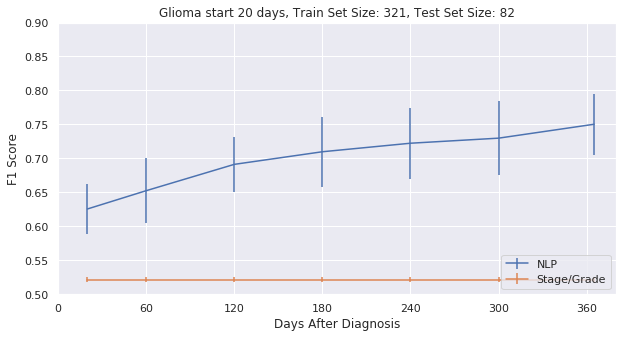

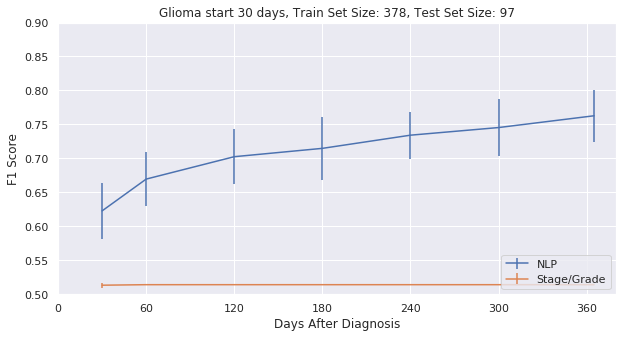

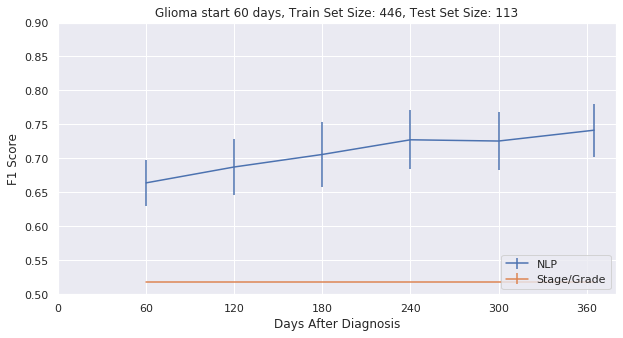

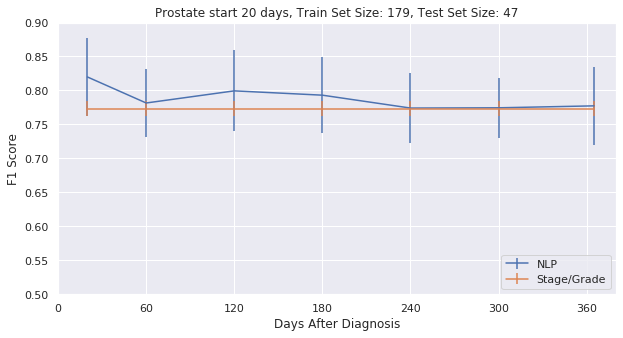

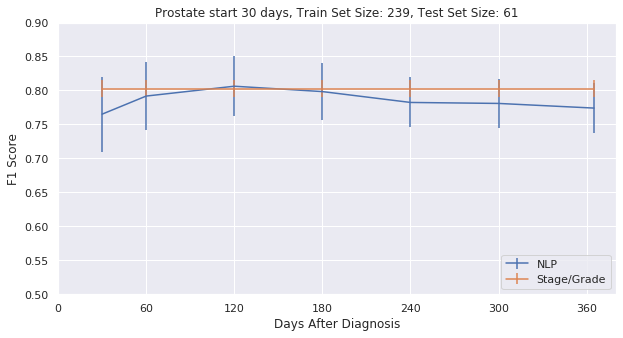

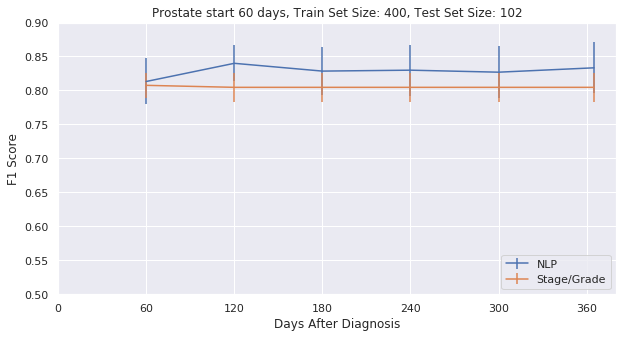

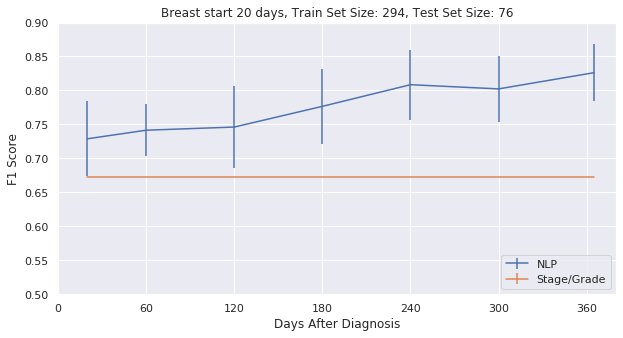

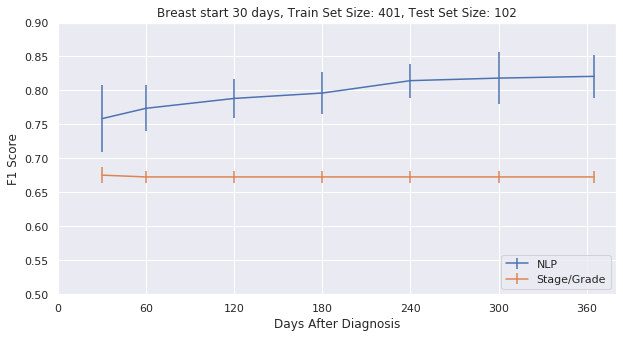

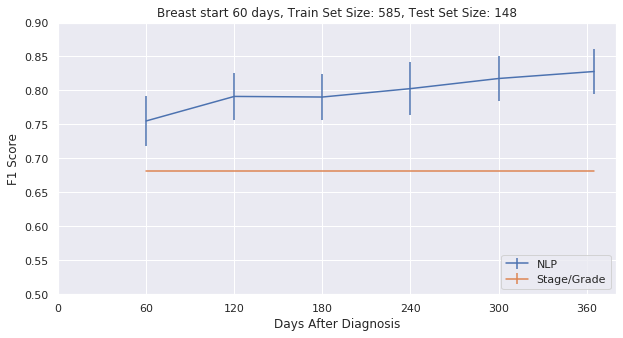

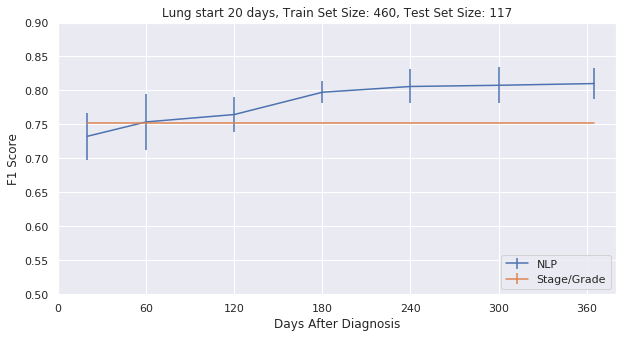

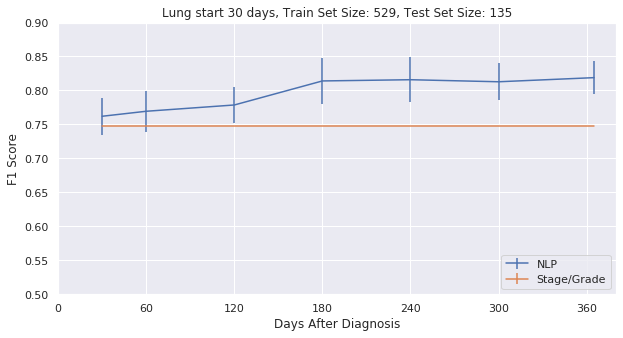

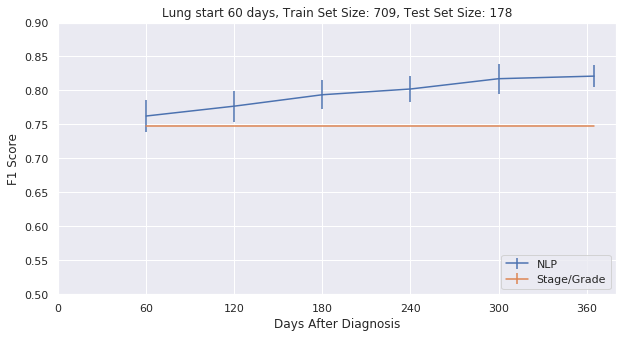

In [7]:
# Plots of time series experiments

for name in list_of_pickle_names:
    with open(PATH+name[0]+SUFFIX+'.pickle', 'rb') as f:
        results_list = pickle.load(f)
        plot_test(results_list, name[0][:1], name[1])



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

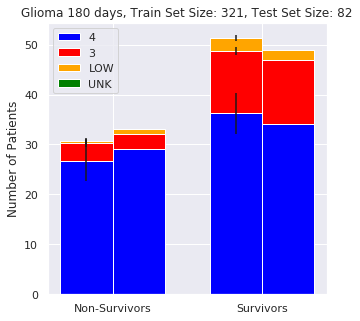

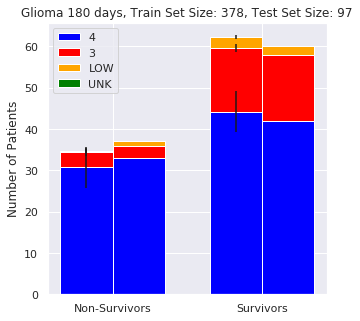

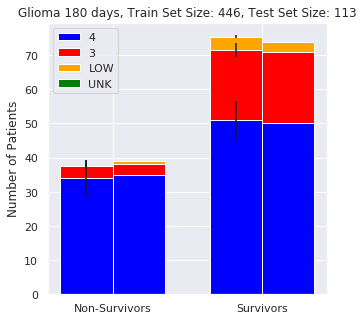

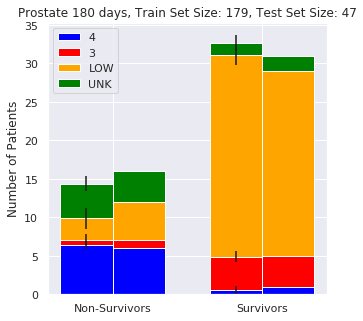

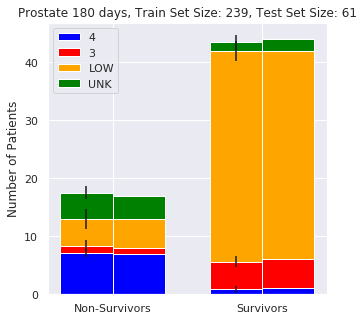

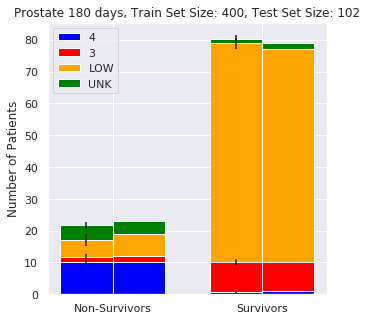

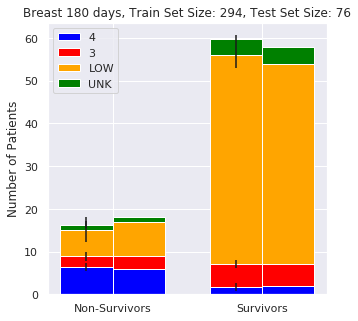

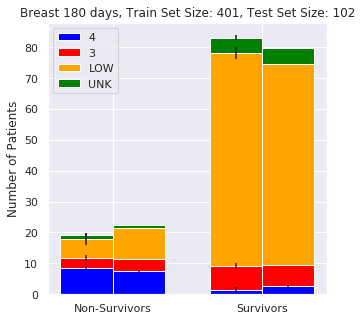

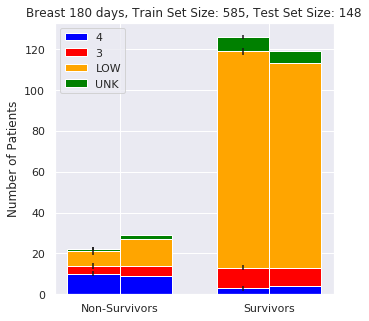

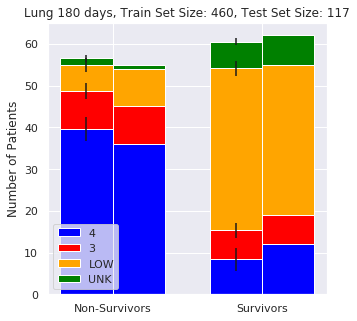

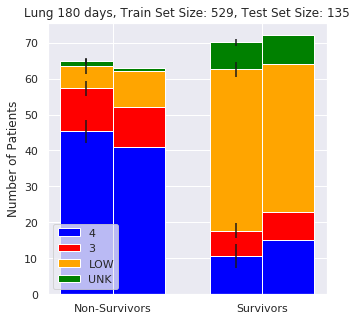

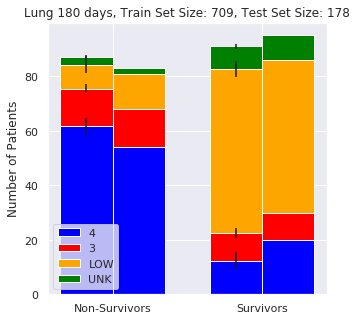

In [8]:
# Test set stage distribution in one point of the experiment.

for name in list_of_pickle_names:
    with open(PATH+name[0]+SUFFIX+'.pickle', 'rb') as f:
        results_list = pickle.load(f)
        plot_test_stage(results_list, name[0][:1], name[1])



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

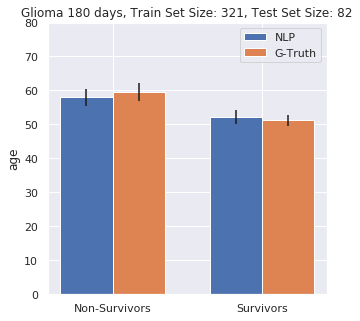

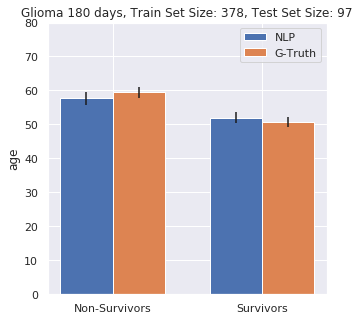

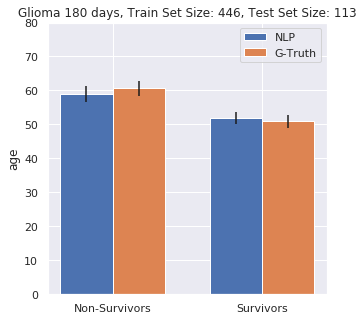

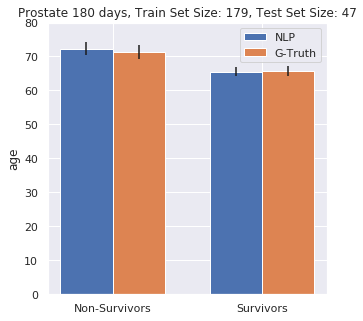

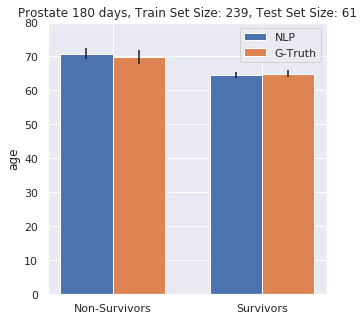

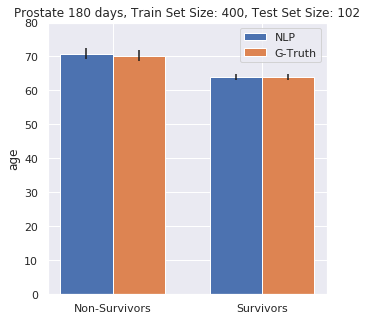

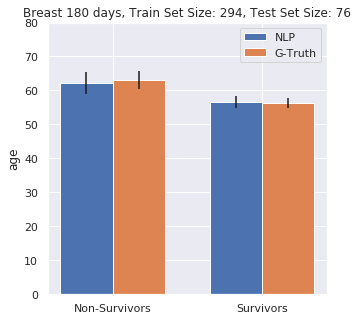

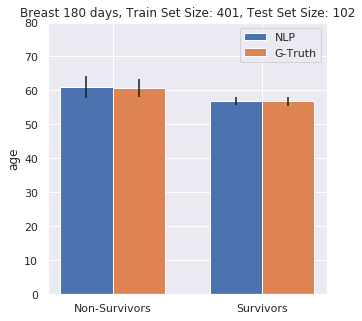

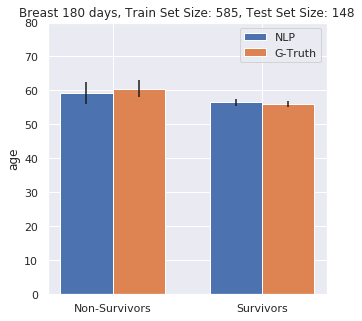

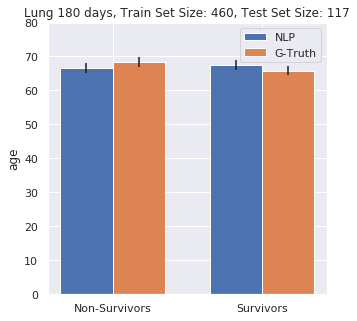

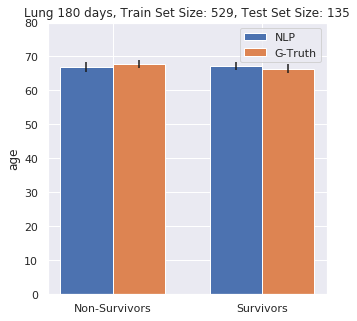

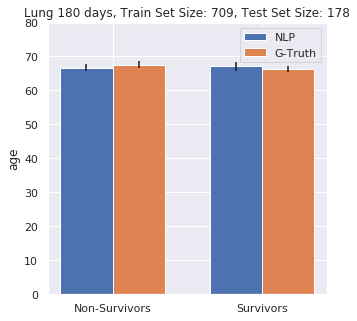

In [9]:
# Test set age distribution in one point of the experiment.

for name in list_of_pickle_names:
    with open(PATH+name[0]+SUFFIX+'.pickle', 'rb') as f:
        results_list = pickle.load(f)
        plot_test_age(results_list, name[0][:1], name[1])
